
**Function 1:**

Searching for Contamination Sources. This may sound simple because you only have a two-dimensional input, however it is a very difficult problem. It corresponds to trying to find the source of radiation in some square area. However, you can only detect the radiation once you are very close to it, meaning most of the readings will be zero. **There are two sources, one is not too dangerous, so make sure you try to find both modes of the function.***

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from scipy.optimize import minimize
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [35]:
f1_inputs = np.load("initial_inputs1.npy")
f1_outputs = np.load("initial_outputs1.npy")
f1_inputs_2 = np.load("initial_inputs2.npy")
f1_outputs_2 = np.load("initial_outputs2.npy")

In [36]:
f1_inputs = np.concatenate((f1_inputs, f1_inputs_2)) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.201607 , 0.5658698]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.785688, 0.49287]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.701023, 0.702999]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.767155, 0.801202]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.756262, 0.621414]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.721023, 0.682999]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.707689, 0.722999]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.716578, 0.705221]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.703245, 0.682999]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.609401, 0.605101]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.629401, 0.589545]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.629401, 0.616212]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.649401, 0.622878]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.631623, 0.636212]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.611623, 0.656212]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.642734, 0.616212]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.651623, 0.620656]]))) 
f1_inputs = np.concatenate((f1_inputs, np.array([[0.642734, 0.616212]]))) 

f1_outputs = np.concatenate((f1_outputs,f1_outputs_2))
f1_outputs = np.append(f1_outputs,-5.9027047474104416e-49)
f1_outputs = np.append(f1_outputs,1.4694233057027134e-30)
f1_outputs = np.append(f1_outputs,6.013687404741693e-08)
f1_outputs = np.append(f1_outputs,1.029025518149088e-34)
f1_outputs = np.append(f1_outputs,3.1568882670317357e-12)
f1_outputs = np.append(f1_outputs,9.594441158769377e-09)
f1_outputs = np.append(f1_outputs,4.4984959147048566e-11)
f1_outputs = np.append(f1_outputs,6.25317474883913e-10)
f1_outputs = np.append(f1_outputs,1.2990004780975896e-06)
f1_outputs = np.append(f1_outputs,0.1971687803797823)
f1_outputs = np.append(f1_outputs,0.0019282695144167755)
f1_outputs = np.append(f1_outputs,1.378994567184674)
f1_outputs = np.append(f1_outputs,0.6197596252221214)
f1_outputs = np.append(f1_outputs,1.6960217184989461)
f1_outputs = np.append(f1_outputs,0.12963516015284113)
f1_outputs = np.append(f1_outputs,0.8437573006254239)
f1_outputs = np.append(f1_outputs,0.4426566990166618)
f1_outputs = np.append(f1_outputs,0.8437573006254239)


In [37]:
X_max= f1_inputs[np.argmax((f1_outputs))]
print(X_max)

[0.649401 0.622878]


In [38]:
Y_max= f1_outputs[np.argmax((f1_outputs))]
print(Y_max)

0.6197596252221214


In [42]:
import math
def costly_function(x):
    total = np.array([])
    for x_i in x:
         total = np.append(total, np.sum(np.exp(-(x_i - 5) ** 2)))
    return total  + np.random.randn()

In [46]:
class BayesianOptimizer():
      
    def __init__(self, target_func, x_init, y_init, n_iter, scale, batch_size):
        self.x_init = x_init
        self.y_init = y_init
        self.target_func = target_func
        self.n_iter = n_iter
        self.scale = scale
        self.batch_size = batch_size
        self.gauss_pr = GaussianProcessRegressor()
        self.best_samples_ = pd.DataFrame(columns = ['x', 'y', 'ei'])
        self.distances_ = []
        
    def _get_expected_improvement(self, x_new):

        # Using estimate from Gaussian surrogate instead of actual function for 
        # a new trial data point to avoid cost 
 
        mean_y_new, sigma_y_new = self.gauss_pr.predict(np.array([x_new]), return_std=True)
        sigma_y_new = sigma_y_new.reshape(-1,1)
        if sigma_y_new == 0.0:
            return 0.0
        
        # Using estimates from Gaussian surrogate instead of actual function for 
        # entire prior distribution to avoid cost
        
        mean_y = self.gauss_pr.predict(self.x_init)
        max_mean_y = np.max(mean_y)-0.001
        z = (mean_y_new - max_mean_y) / sigma_y_new
        exp_imp = (mean_y_new - max_mean_y) * norm.cdf(z) + sigma_y_new * norm.pdf(z)
        
        return exp_imp
    def _acquisition_function(self, x):
        return -self._get_expected_improvement(x)
    
    def _get_next_probable_point(self):
            min_ei = float(sys.maxsize)
            x_optimal = None 
            
            # Trial with an array of random data points
            
            for x_start in np.random.uniform(low=0.1, high=0.99, size=(1,2)):
                response = minimize(fun=self._acquisition_function, x0=x_start, method='L-BFGS-B')
                if response.fun < min_ei:
                    min_ei = response.fun
                    x_optimal = response.x
            
            return x_optimal, min_ei
    def _extend_prior_with_posterior_data(self, x,y):
        self.x_init = np.append(self.x_init, np.array([x]), axis = 0)
        self.y_init = np.append(self.y_init, np.array(y), axis = 0)
        
    def optimize(self):
        y_max_ind = np.argmax(self.y_init)
        y_max = self.y_init[y_max_ind]
        optimal_x = self.x_init[y_max_ind]
        optimal_ei = None
        for i in range(self.n_iter):
            self.gauss_pr.fit(self.x_init, self.y_init)
            x_next, ei = self._get_next_probable_point()
            y_next = self.target_func(np.array([x_next]))
            self._extend_prior_with_posterior_data(x_next,y_next)
            
            if y_next[0] > y_max:
                y_max = y_next[0]
                optimal_x = x_next
                optimal_ei = ei

            if i == 0:
                 prev_x = x_next
            else:
                self.distances_.append(np.linalg.norm(prev_x - x_next))
                prev_x = x_next
            tmpdf = pd.DataFrame({"y": y_max, "ei": optimal_ei},index=[1])
            #self.best_samples_ = self.best_samples_.append({"y": y_max, "ei": optimal_ei},ignore_index=True)
            self.best_samples_ =pd.concat([self.best_samples_ ,tmpdf],ignore_index = True)
        
        return optimal_x, y_max
  
  
        

In [47]:
sample_x = f1_inputs
sample_y = f1_outputs

In [48]:
bopt = BayesianOptimizer(target_func=costly_function, x_init=sample_x, y_init=sample_y, n_iter=200, scale=10, batch_size=30)
bopt.optimize()

(array([0.55855969, 0.23238164]), 2.2455688694697127)

In [10]:
#(array([0.21282251, 0.98147054]), 2.708183766327179)
#(array([0.80370727, 0.75831683]), 3.2487751185572926)
#(array([0.76715593, 0.80120279]), 2.6396537939477724)

In [13]:
f1_inputs

array([[0.31940389, 0.76295937],
       [0.57432921, 0.8798981 ],
       [0.73102363, 0.73299988],
       [0.84035342, 0.26473161],
       [0.65011406, 0.68152635],
       [0.41043714, 0.1475543 ],
       [0.31269116, 0.07872278],
       [0.68341817, 0.86105746],
       [0.08250725, 0.40348751],
       [0.88388983, 0.58225397],
       [0.90048221, 0.46996691],
       [0.86243528, 0.4352856 ],
       [0.09311333, 0.31520745],
       [0.48975434, 0.16844847],
       [0.90132685, 0.67366454],
       [0.32101719, 0.63497061],
       [0.32044659, 0.42030664],
       [0.63861791, 0.73839723],
       [0.59648578, 0.61407967],
       [0.48366726, 0.31942835],
       [0.96227495, 0.90831843],
       [0.46937596, 0.55313941],
       [0.06938944, 0.62671938],
       [0.59640851, 0.81673367],
       [0.1409109 , 0.3179331 ],
       [0.58653471, 0.20732755],
       [0.61533925, 0.18320905],
       [0.9068703 , 0.76151747],
       [0.58038966, 0.57243686],
       [0.55684911, 0.58265192],
       [0.

In [14]:
f1_outputs

array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048, -3.23831206e-070, -2.66554974e-065,
       -6.53456227e-084,  1.33208482e-048,  2.94212475e-055,
        8.33516100e-040, -5.03981978e-008, -2.01007653e-009,
        6.59147585e-002,  5.59549084e-011,  4.50954445e-133,
       -4.05280070e-015, -7.40958578e-118,  8.49132032e-027,
       -8.80550875e-064, -9.89621108e-052, -2.68384158e-067,
        1.19343278e-067,  6.90381175e-005,  4.65270195e-006,
       -5.90270475e-049,  1.46942331e-030,  6.01368740e-008,
        1.02902552e-034,  3.15688827e-012,  9.59444116e-009,
        4.49849591e-011,  6.25317475e-010,  1.29900048e-006,
        1.97168780e-001])

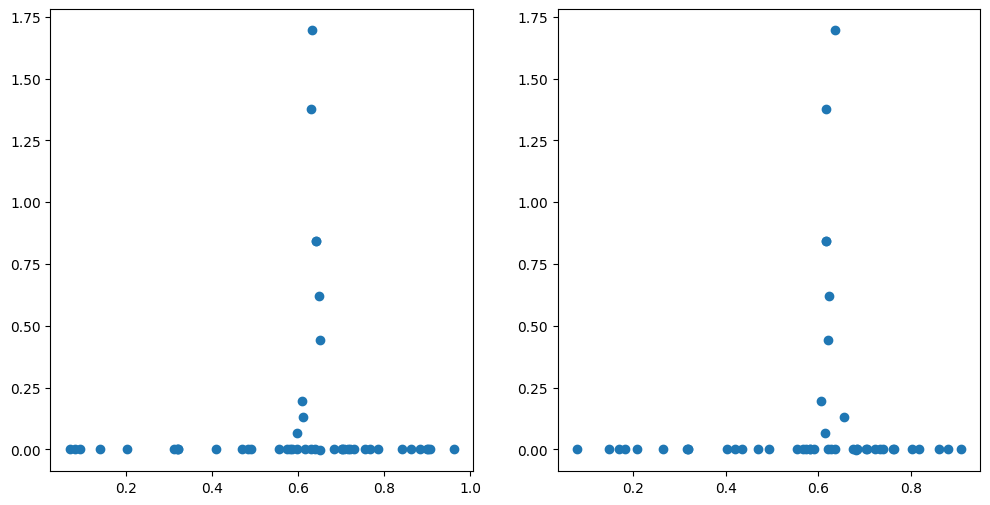

In [13]:
fig, ax = plt.subplots(1,2,figsize = (12,6))
ax[0].scatter(f1_inputs[:,0],f1_outputs)
ax[1].scatter(f1_inputs[:,1],f1_outputs)
plt.show()